In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from scipy.stats import ks_2samp
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import metrics
df=pd.read_csv('order_table_50k_v3.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   order_id             50000 non-null  int64  
 1   user_id              50000 non-null  int64  
 2   order_date           50000 non-null  object 
 3   age                  50000 non-null  float64
 4   fico_score           50000 non-null  int64  
 5   score1               50000 non-null  int64  
 6   score2               50000 non-null  float64
 7   ethnicity            50000 non-null  object 
 8   medical_records_12m  50000 non-null  int64  
 9   income               50000 non-null  int64  
 10  principal            50000 non-null  int64  
 11  term                 50000 non-null  int64  
 12  interest             50000 non-null  int64  
 13  order_status         50000 non-null  int64  
 14  fpd30                50000 non-null  int64  
 15  mob3_m2              50000 non-null 

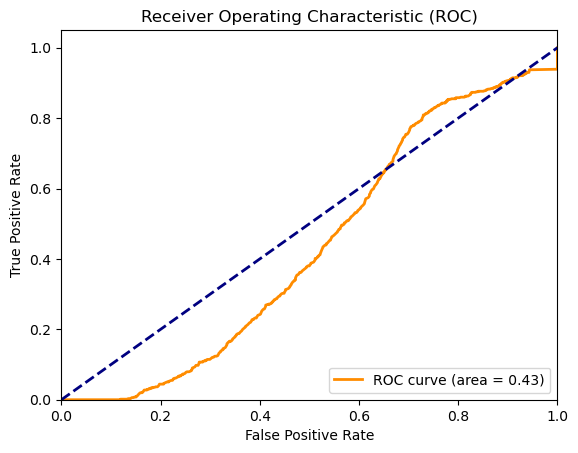

In [106]:
y_true = df['mob3_m2']  # 真实标签
y_scores = df['score2']  # 预测分数

# 计算ROC曲线和AUC
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_scores)
roc_auc = metrics.auc(fpr, tpr)

# 绘制ROC曲线
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [15]:
#计算AUC
try:
    auc = roc_auc_score(df['fpd30'], df['score2'])
    print(f"模型对label mob3_m2的AUC为: {auc}")
except ValueError as e:
    print(f"计算AUC时出现错误: {e}")
########################################################
#计算K-S
# 提取正例（标签为1）的预测分数
positive_scores = df[df['fpd30'] == 1]['score2']
# 提取所有样本的预测分数，用于形成对照组
all_scores = df['score1']
# 计算KS值
try:
    ks_statistic, ks_pvalue = ks_2samp(positive_scores, all_scores)
    print(f"KS统计量: {ks_statistic}, p值: {ks_pvalue}")
    # KS统计量越大，说明预测概率与实际标签的分离程度越好
    # p值用于检验假设检验的显著性，一般小于0.05认为两组分布有显著差异
except Exception as e:
    print(f"计算KS值时出现错误: {e}")

模型对label mob3_m2的AUC为: 0.4061359036802311
KS统计量: 0.20000891719745229, p值: 5.566092201829464e-06


In [19]:
#计算PSI 2009年和2010年的PSI
def calculate_psi(current_distribution, reference_distribution):
    """
    计算两个分布之间的PSI。
    :param current_distribution: 当前分布的Series或列表，包含每个bin的频数。
    :param reference_distribution: 参考分布的Series或列表，格式同上。
    :return: PSI值。
    """
    n_bins = len(current_distribution)
    total_count = sum(current_distribution) + sum(reference_distribution)
    
    def psi_bin(bin_index):
        actual = current_distribution[bin_index] / total_count
        expected = reference_distribution[bin_index] / total_count
        if expected == 0:
            expected = 0.0001  # 防止除以零错误
        return actual * abs(np.log(actual / expected))
    
    psi_values = [psi_bin(i) for i in range(n_bins)]
    return np.sum(psi_values)

# 假设df是包含order_date和score1字段的DataFrame
df['order_date'] = pd.to_datetime(df['order_date'])  # 确保order_date是datetime类型

# 按年份分割数据
df_2009 = df[df['order_date'].dt.year == 2009]
df_2010 = df[df['order_date'].dt.year == 2010]

# 对score1进行分箱，这里简化处理，假设已经对score1进行了合适的分箱并计算了频数
# 实际应用中，你可能需要根据数据具体情况确定合适的分箱方法和区间
# 这里仅作为示意，假设我们已经有了分箱后的频数分布
# bins_2009, bins_2010 代表2009年和2010年score1的分布频数，具体实现需根据实际数据调整

# 为了演示，我们假设一个简单的分箱过程，分5箱
bins = pd.cut(df['score2'], bins=5, labels=False, include_lowest=True)  # 5个等宽分箱
dist_2009 = df_2009.groupby(bins).size() / len(df_2009)  # 计算各分箱的频率
dist_2010 = df_2010.groupby(bins).size() / len(df_2010)  # 同上

# 计算PSI
psi_value = calculate_psi(dist_2010, dist_2009)  # 注意顺序，一般是新分布对老分布
print(f"2009年到2010年之间的PSI值为: {psi_value}")

2009年到2010年之间的PSI值为: 0.01273124242432878


In [96]:
bins = pd.qcut(df['score2'], q=10, duplicates='drop')
df['bins']=bins
grouped_counts = df.groupby(['bins', 'mob3_m2']).size()
proportions = grouped_counts.xs(1, level='mob3_m2') / df.groupby('bins')['mob3_m2'].count()
proportions

/var/folders/f7/2frpmg2s6c74mpj4t1csv3x40000gp/T/ipykernel_93947/1228376056.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_counts = df.groupby(['bins', 'mob3_m2']).size()
/var/folders/f7/2frpmg2s6c74mpj4t1csv3x40000gp/T/ipykernel_93947/1228376056.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportions = grouped_counts.xs(1, level='mob3_m2') / df.groupby('bins')['mob3_m2'].count()


bins
(340.711, 451.0]    0.012171
(451.0, 513.0]      0.006279
(513.0, 557.0]      0.013633
(557.0, 595.0]      0.028398
(595.0, 631.0]      0.020767
(631.0, 666.0]      0.018156
(666.0, 703.0]      0.016439
(703.0, 748.0]      0.009646
(748.0, 800.0]      0.002901
dtype: float64

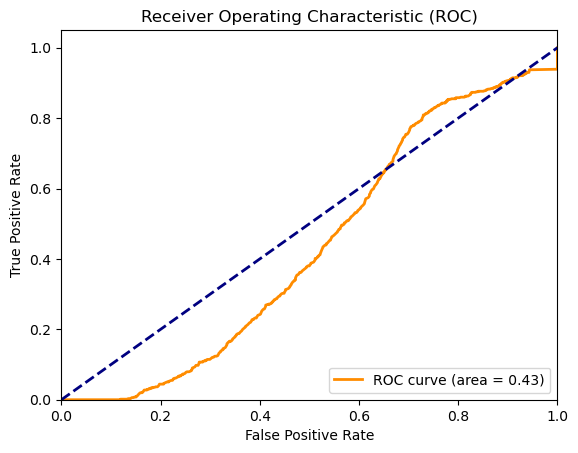